In [1]:
!pip install --quiet huggingface_hub

In [4]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from collections import Counter
import huggingface_hub
import os
import warnings
import time

In [5]:
# Login is optional for public models
# huggingface_hub.login()

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Ignore warning to create a token
    corpus_file_path = huggingface_hub.hf_hub_download(
        repo_id="ardMLX/text8",
        filename="text8",
        repo_type="dataset",
        local_dir="."
    )

print(f"File downloaded to: {corpus_file_path}")

File downloaded to: text8


In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: mps


In [8]:
def tokenize(text):
    return text.lower().split()

# TODO Use torchtext.vocab.build_vocab_from_iterator
def build_vocab(tokens, min_freq=1):
    counter = Counter(tokens)
    vocab = {word: idx for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    word2idx = {word: i for i, word in enumerate(vocab)}
    idx2word = {i: word for word, i in word2idx.items()}
    return word2idx, idx2word

## CBOW

In [9]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # TODO Do we have to do max norm here?
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, max_norm=1.0)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        x = self.embeddings(inputs)
        x = x.mean(dim=1)
        x = self.linear(x)
        return x

In [10]:
class CBOWDataset(Dataset):
    def __init__(self, tokens, word2idx, context_size=2):
        self.data = []
        self.word2idx = word2idx
        self.context_size = context_size
        self.vocab_size = len(word2idx)

        indices = [word2idx[word] for word in tokens if word in word2idx]
        # TODO add tqdm progress
        for i in range(context_size, len(indices) - context_size):
            context = (
                indices[i - context_size:i] + indices[i + 1:i + context_size + 1]
            )
            target = indices[i]
            self.data.append((context, target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [11]:
def print_closest_words(model, word2idx, idx2word, words, device, top_k=5):
    embeddings = model.embeddings.weight.data
    norm = embeddings / embeddings.norm(dim=1, keepdim=True)
    for word in words:
        if word not in word2idx:
            print(f"{word}: not in vocabulary")
            continue
        idx = word2idx[word]
        query = norm[idx]
        similarities = torch.matmul(norm, query)
        nearest = similarities.topk(top_k + 1).indices[1:]  # exclude self
        nearest_words = [idx2word[i.item()] for i in nearest]
        print(f"{word}: {', '.join(nearest_words)}")

In [12]:
def train_model(model, dataloader, num_epochs, lr, device):
    model.to(device)
    # TODO Use torch.optim.lr_scheduler to decay learning rate
    # TODO See how nn.CrossEntropyLoss is implemented
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        total_loss = 0
        for i, (context, target) in enumerate(dataloader):
            context, target = context.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(context)
            loss = criterion(output, target)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            if i % 1000 == 0:
                print(f"Time: {time.strftime('%Y-%m-%d %H:%M:%S')}, Epoch {epoch+1}, Step {i}, Loss: {loss.item():.4f}")
            if i % 10000 == 0:
                print("\nClosest words to some test words:")
                eval_words = ["king", "man", "woman", "computer", "music"]
                print_closest_words(model, word2idx, idx2word, eval_words, device, top_k=5)

                snapshot_path = f"cbow_epoch{epoch+1}_step{i}.pt"
                torch.save(model.state_dict(), snapshot_path)
                print(f"Model snapshot saved to {snapshot_path}")


In [13]:
# Load and process text
with open(corpus_file_path, "r") as f:
    tokens = tokenize(f.read())

# Build vocab
word2idx, idx2word = build_vocab(tokens, min_freq=1)

# Create dataset and dataloader
context_size = 2
dataset = CBOWDataset(tokens, word2idx, context_size=context_size)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
len(word2idx)

253854

In [15]:
len(dataset)

17005203

In [16]:
len(dataloader)

531413

In [17]:
# Create model and train
vocab_size = len(word2idx)
embedding_dim = 100
model = CBOW(vocab_size, embedding_dim)
print(model)

CBOW(
  (embeddings): Embedding(253854, 100, max_norm=1.0)
  (linear): Linear(in_features=100, out_features=253854, bias=True)
)


In [ ]:
train_model(model, dataloader, num_epochs=1, lr=0.001, device=device)

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/functional.py:2434: UserWarning: The operator 'aten::embedding_renorm_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  torch.embedding_renorm_(weight.detach(), input, max_norm, norm_type)


Time: 2025-06-11 14:04:12, Epoch 1, Step 0, Loss: 12.4774

Closest words to some test words:
king: rber, abu, gaber, katzenjammer, vater
man: salafist, docherty, nemausus, ogili, aymer
woman: senat, morgul, austrinus, moonwalkers, ramjets
computer: majed, ebooks, tsom, dho, hybrid
music: pathe, vascularity, banuera, topi, failghe
Model snapshot saved to cbow_epoch1_step0.pt
Time: 2025-06-11 14:06:26, Epoch 1, Step 1000, Loss: 9.0032
Time: 2025-06-11 14:08:34, Epoch 1, Step 2000, Loss: 6.9895
Time: 2025-06-11 14:10:53, Epoch 1, Step 3000, Loss: 9.1863
Time: 2025-06-11 14:13:10, Epoch 1, Step 4000, Loss: 7.8078
Time: 2025-06-11 14:15:26, Epoch 1, Step 5000, Loss: 8.0979
Time: 2025-06-11 14:17:43, Epoch 1, Step 6000, Loss: 7.3938
Time: 2025-06-11 14:20:11, Epoch 1, Step 7000, Loss: 7.3737
Time: 2025-06-11 14:22:39, Epoch 1, Step 8000, Loss: 7.5670
Time: 2025-06-11 14:25:21, Epoch 1, Step 9000, Loss: 8.7345
Time: 2025-06-11 14:28:46, Epoch 1, Step 10000, Loss: 7.2708

Closest words to some

In [ ]:
torch.save(model.state_dict(), f"cbow_final.pt")

In [63]:
# Save model state_dict along with word2idx and idx2word
torch.save({
    'model_state_dict': model.state_dict(),
    'word2idx': word2idx,
    'idx2word': idx2word
}, "cbow_final_with_vocab.pt")

In [66]:
checkpoint = torch.load("cbow_final_with_vocab.pt", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
word2idx = checkpoint['word2idx']
idx2word = checkpoint['idx2word']

In [58]:
small_word_groups = {
    "Countries": ["france", "germany", "spain", "italy", "china", "japan", "india", "brazil", "canada", "russia"],
    "Cities": ["paris", "berlin", "rome", "madrid", "beijing", "tokyo", "delhi", "toronto", "moscow", "london"],
    "Animals": ["cat", "dog", "lion", "tiger", "elephant", "giraffe", "horse", "monkey", "bear", "zebra"],
    "Fruits": ["apple", "banana", "orange", "grape", "pear", "peach", "mango", "pineapple", "kiwi", "cherry"],
    "Professions": ["doctor", "nurse", "teacher", "engineer", "lawyer", "pilot", "chef", "artist", "scientist", "farmer"],
    "Emotions": ["happy", "sad", "angry", "excited", "bored", "afraid", "proud", "jealous", "grateful", "lonely"],
    "Colors": ["red", "blue", "green", "yellow", "purple", "pink", "orange", "black", "white", "gray"],
    "Technology": ["computer", "internet", "software", "hardware", "robot", "ai", "algorithm", "network", "database", "server"],
    "Body Parts": ["hand", "foot", "head", "leg", "arm", "eye", "ear", "nose", "mouth", "back"],
    "Clothing": ["shirt", "pants", "jacket", "shoes", "hat", "dress", "socks", "scarf", "jeans", "coat"]
}

In [59]:
big_word_groups = {
    "Countries": [
        "france", "germany", "spain", "italy", "china", "japan", "india", "brazil", "canada", "russia",
        "australia", "argentina", "egypt", "mexico", "turkey", "indonesia", "iran", "nigeria", "kenya", "ukraine"
    ],
    "Cities": [
        "paris", "berlin", "rome", "madrid", "beijing", "tokyo", "delhi", "toronto", "moscow", "london",
        "new_york", "los_angeles", "chicago", "seoul", "bangkok", "sydney", "vienna", "dubai", "cairo", "barcelona"
    ],
    "Animals": [
        "cat", "dog", "lion", "tiger", "elephant", "giraffe", "horse", "monkey", "bear", "zebra",
        "rabbit", "deer", "fox", "wolf", "leopard", "panda", "kangaroo", "penguin", "dolphin", "whale"
    ],
    "Fruits": [
        "apple", "banana", "orange", "grape", "pear", "peach", "mango", "pineapple", "kiwi", "cherry",
        "strawberry", "blueberry", "raspberry", "lemon", "lime", "apricot", "plum", "watermelon", "coconut", "fig"
    ],
    "Vegetables": [
        "carrot", "potato", "onion", "tomato", "cabbage", "lettuce", "broccoli", "spinach", "pepper", "cucumber",
        "zucchini", "cauliflower", "radish", "turnip", "eggplant", "pumpkin", "pea", "corn", "garlic", "beet"
    ],
    "Professions": [
        "doctor", "nurse", "teacher", "engineer", "lawyer", "pilot", "chef", "artist", "scientist", "farmer",
        "journalist", "architect", "mechanic", "plumber", "carpenter", "firefighter", "policeman", "actor", "singer", "dancer"
    ],
    "Emotions": [
        "happy", "sad", "angry", "excited", "bored", "afraid", "proud", "jealous", "grateful", "lonely",
        "confused", "hopeful", "nervous", "calm", "depressed", "anxious", "curious", "relaxed", "content", "ashamed"
    ],
    "Colors": [
        "red", "blue", "green", "yellow", "purple", "pink", "orange", "black", "white", "gray",
        "brown", "cyan", "magenta", "turquoise", "beige", "lavender", "gold", "silver", "maroon", "navy"
    ],
    "Technology": [
        "computer", "internet", "software", "hardware", "robot", "ai", "algorithm", "network", "database", "server",
        "cloud", "blockchain", "python", "java", "html", "javascript", "linux", "iphone", "android", "machine_learning"
    ],
    "Body Parts": [
        "hand", "foot", "head", "leg", "arm", "eye", "ear", "nose", "mouth", "back",
        "chest", "stomach", "knee", "elbow", "shoulder", "neck", "wrist", "ankle", "finger", "toe"
    ],
    "Clothing": [
        "shirt", "pants", "jacket", "shoes", "hat", "dress", "socks", "scarf", "jeans", "coat",
        "gloves", "skirt", "boots", "sweater", "belt", "tie", "shorts", "blouse", "hoodie", "suit"
    ],
    "Weather": [
        "rain", "snow", "sun", "cloud", "storm", "wind", "fog", "hail", "lightning", "thunder",
        "temperature", "humidity", "sunny", "rainy", "cloudy", "stormy", "windy", "foggy", "hot", "cold"
    ],
    "Sports": [
        "football", "basketball", "tennis", "cricket", "baseball", "golf", "boxing", "swimming", "running", "cycling",
        "skiing", "snowboarding", "volleyball", "badminton", "hockey", "wrestling", "karate", "surfing", "skating", "fencing"
    ],
    "Vehicles": [
        "car", "bus", "train", "bicycle", "motorcycle", "airplane", "helicopter", "boat", "ship", "submarine",
        "truck", "scooter", "van", "taxi", "tram", "yacht", "jet", "ferry", "canoe", "wagon"
    ],
    "Buildings": [
        "house", "apartment", "school", "hospital", "church", "mosque", "temple", "castle", "palace", "skyscraper",
        "library", "hotel", "restaurant", "theater", "museum", "stadium", "barn", "cabin", "garage", "tower"
    ],
    "Instruments": [
        "guitar", "piano", "violin", "drum", "flute", "trumpet", "saxophone", "cello", "clarinet", "harp",
        "trombone", "banjo", "accordion", "xylophone", "oboe", "tuba", "mandolin", "ukulele", "bass", "organ"
    ]
}

In [60]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def visualize_embeddings(word_groups, embeddings, word2idx):

    # --- Prepare Data ---
    all_words = []
    word_labels = []
    group_labels = []

    for group, words in word_groups.items():
        for word in words:
            if word in word2idx:
                all_words.append(word)
                word_labels.append(word)
                group_labels.append(group)

    # Get embeddings
    indices = [word2idx[w] for w in all_words]
    selected_embeds = embeddings[indices]

    # --- Reduce Dimensions ---
    pca = PCA(n_components=30, random_state=42)
    reduced = pca.fit_transform(selected_embeds)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
    embeds_2d = tsne.fit_transform(reduced)

    # --- Plot ---
    plt.figure(figsize=(18, 16))

    # Assign unique colors
    groups = sorted(set(group_labels))
    colors = cm.get_cmap('tab10', len(groups))

    for i, group in enumerate(groups):
        indices = [j for j, g in enumerate(group_labels) if g == group]
        x = embeds_2d[indices, 0]
        y = embeds_2d[indices, 1]
        plt.scatter(x, y, label=group, s=100, alpha=0.7, color=colors(i))
        for j in indices:
            plt.annotate(word_labels[j], (embeds_2d[j, 0], embeds_2d[j, 1]), fontsize=12)

    plt.title("t-SNE Visualization of Word Embeddings by Semantic Group", fontsize=22)
    plt.legend(fontsize=14, loc='best')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

/var/folders/rj/d19lxfn1483btqgkk1kgg95c0000gp/T/ipykernel_24576/2546884289.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(groups))


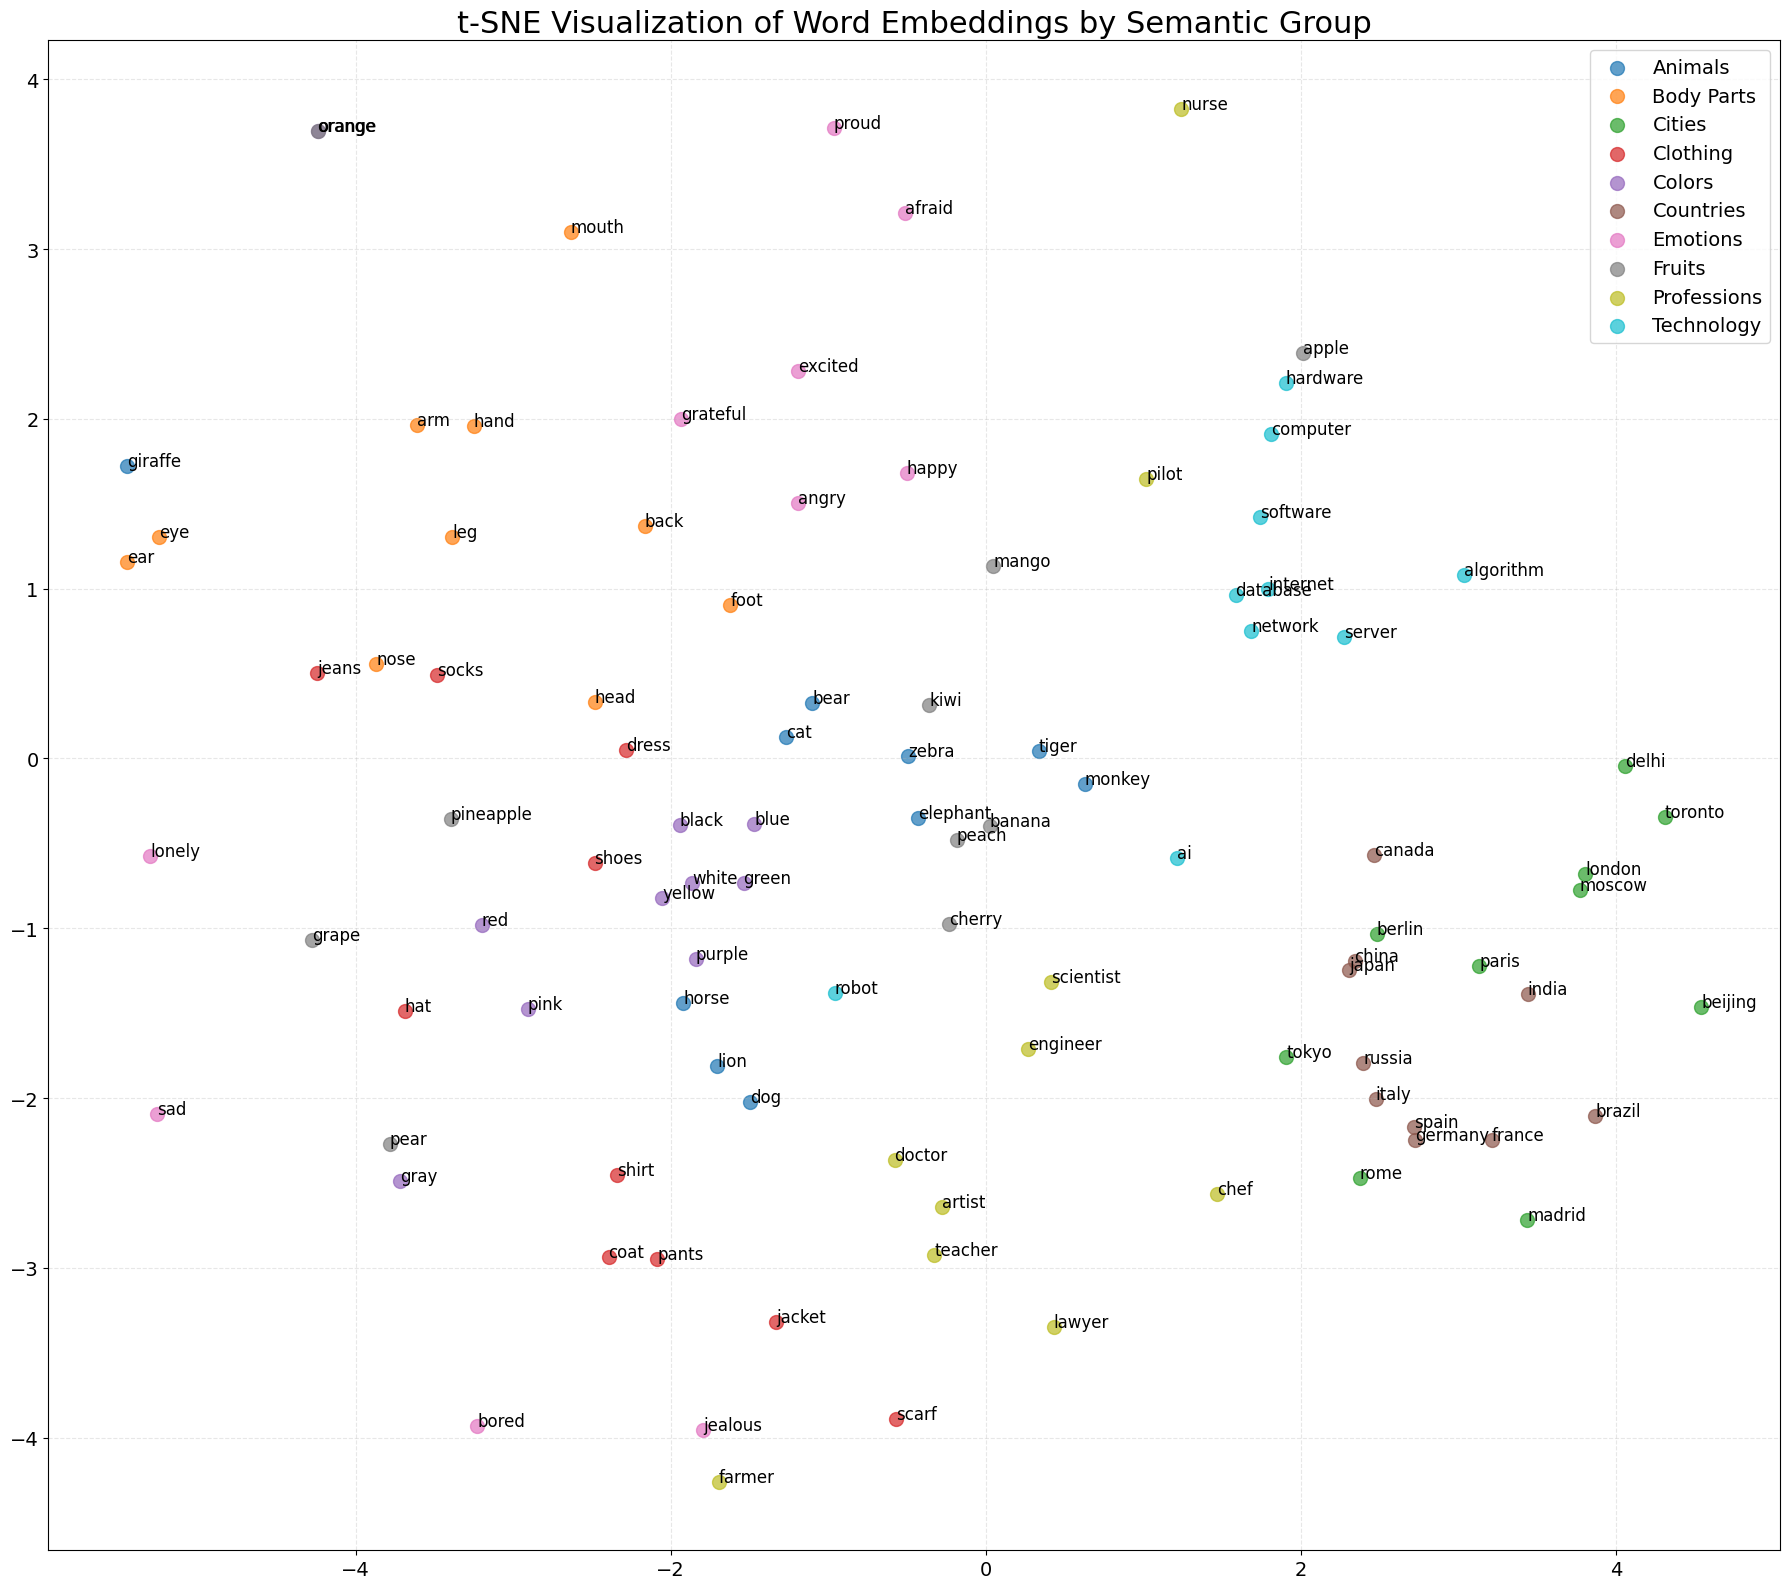

In [61]:
visualize_embeddings(small_word_groups, model.embeddings.weight.data.cpu().numpy(), word2idx)

In [50]:
def visualize_embeddings_from_file(file_path):
    raw_data = torch.load(file_path, map_location=torch.device('cpu'))
    embeddings = raw_data['embeddings']
    word2idx = raw_data['word_to_ix']
    visualize_embeddings(embeddings, word2idx)